In [1]:
# %matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Loading Raw Data

In [2]:
# every features in the dataset
header_list = {
0: 'label',
1: 'lepton 1 pT',
2: 'lepton 1 eta',
3: 'lepton 1 phi',
4: 'lepton 2 pT',
5: 'lepton 2 eta',
6: 'lepton 2 phi',
7: 'missing energy magnitude',
8: 'missing energy phi',
9: 'MET_rel',
10: 'axial MET',
11: 'M_R',
12: 'M_TR_2',
13: 'R',
14: 'MT2',
15: 'S_R',
16: 'M_Delta_R',
17: 'dPhi_r_b',
18: 'cos(theta_r1)'
}


# best features according to reference [1]
important_features = [
                      'lepton 1 pT',
                      'lepton 2 pT',
                      'missing energy magnitude',
                      'M_TR_2',
                      'M_Delta_R',
                      'lepton 1 eta',
                      'lepton 2 eta'
]

important_features_id = np.array([
                         0,
                         3,
                         6,
                         11,
                         15,
                         1,
                         4
])

In [3]:
num_sample = 5000

X_train = np.loadtxt('./SUSY Dataset/X_train_' + str(num_sample) + '.txt')
Y_train = np.loadtxt('./SUSY Dataset/Y_train_' + str(num_sample) + '.txt')

X_test = np.loadtxt('./SUSY Dataset/X_test_' + str(num_sample) + '.txt')
Y_test = np.loadtxt('./SUSY Dataset/Y_test_' + str(num_sample) + '.txt')

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(5000, 18) (5000,)
(5000, 18) (5000,)


# Dataset Preprocessing (Standardization + PCA)

## Standardization

In [ ]:
def normalize(X, use_params=False, params=None):
    """Normalize the given dataset X
    Args:
        X: ndarray, dataset
    
    Returns:
        (Xbar, mean, std): tuple of ndarray, Xbar is the normalized dataset
        with mean 0 and standard deviation 1; mean and std are the 
        mean and standard deviation respectively.
    
    Note:
        You will encounter dimensions where the standard deviation is
        zero, for those when you do normalization the normalized data
        will be NaN. Handle this by setting using `std = 1` for those 
        dimensions when doing normalization.
    """
    if use_params:
        mu = params[0]
        std_filled = [1]
    else:
        mu = np.mean(X, axis=0)
        std = np.std(X, axis=0)
        #std_filled = std.copy()
    #std_filled[std==0] = 1.
    Xbar = (X - mu)/(std + 1e-8)
    return Xbar, mu, std


In [ ]:
X_train, mu_train, std_train = normalize(X_train)
X_train.shape, Y_train.shape

((5000, 18), (5000,))

In [ ]:
X_test = (X_test - mu_train)/(std_train + 1e-8)
X_test.shape, Y_test.shape

((5000, 18), (5000,))

## PCA

In [ ]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

In [ ]:
num_component = 9
pca = PCA(n_components=num_component, svd_solver='full')

In [ ]:
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=9, random_state=None,
    svd_solver='full', tol=0.0, whiten=False)

In [ ]:
np.cumsum(pca.explained_variance_ratio_)

array([0.26578131, 0.47431056, 0.55821074, 0.63681255, 0.70762049,
       0.76512132, 0.82005821, 0.86680636, 0.90453854])

In [ ]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [ ]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(5000, 9) (5000,)
(5000, 9) (5000,)


## Norm

In [ ]:
X_train = (X_train.T / np.sqrt(np.sum(X_train ** 2, -1))).T
X_test = (X_test.T / np.sqrt(np.sum(X_test ** 2, -1))).T

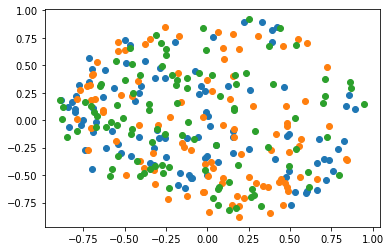

In [ ]:
plt.scatter(X_train[:100, 0], X_train[:100, 1])
plt.scatter(X_train[100:200, 0], X_train[100:200, 1])
plt.scatter(X_train[200:300, 0], X_train[200:300, 1])

## Standard Scaling

In [ ]:
X_train = 2*((X_train - np.min(X_train, axis=0))/(np.max(X_train, axis=0) - np.min(X_train, axis=0))) - 1
X_test = 2*((X_test - np.min(X_test, axis=0))/(np.max(X_test, axis=0) - np.min(X_test, axis=0))) - 1

## Best Features

In [4]:
X_train = X_train[:, important_features_id[:6]]
X_test = X_test[:, important_features_id[:6]]

X_train.shape, X_test.shape

((5000, 6), (5000, 6))

# Quantum

In [5]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer

qml.enable_tape()


# Set a random seed
np.random.seed(42)

In [6]:
# Define output labels as quantum state vectors

# def density_matrix(state):
#     """Calculates the density matrix representation of a state.

#     Args:
#         state (array[complex]): array representing a quantum state vector

#     Returns:
#         dm: (array[complex]): array representing the density matrix
#     """
#     return state * np.conj(state).T


label_0 = [[1], [0]]
label_1 = [[0], [1]]


def density_matrix(state):
    """Calculates the density matrix representation of a state.

    Args:
        state (array[complex]): array representing a quantum state vector

    Returns:
        dm: (array[complex]): array representing the density matrix
    """
    return np.outer(state,  np.conj(state))

state_labels = [label_0, label_1]
#state_labels = np.loadtxt('./tetra_states.txt', dtype=np.complex_)

In [7]:
dm_labels = [density_matrix(state_labels[i]) for i in range(2)]
len(dm_labels)

2

In [8]:
dm_labels

[tensor([[1, 0],
         [0, 0]], requires_grad=True),
 tensor([[0, 0],
         [0, 1]], requires_grad=True)]

In [9]:
binary_class = np.array([[1, 0], [0, 1]])
class_labels = binary_class

In [10]:
num_fc_layer = 5
#params_fix = np.random.uniform(size=(2, num_fc_layer, 6))

In [11]:
device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"
device_rigetti = "arn:aws:braket:::device/qpu/rigetti/Aspen-9"
# Please enter the S3 bucket you created during onboarding
# (or any other S3 bucket starting with 'amazon-braket-' in your account) in the code below

my_bucket = f"amazon-braket-edo" # the name of the bucket
my_prefix = "edo-testing" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

In [18]:
n_samples = 10
n_qubits = n_samples  # number of class
#dev_fc = qml.device("default.qubit", wires=n_qubits)

#layer_id = 4

#dev_braket_local = qml.device("braket.local.qubit", wires=1)
#dev_braket_aws = qml.device('braket.aws.qubit', device_arn=device_arn, wires=1, s3_destination_folder=s3_folder)

dev_rigetti_aws = qml.device('braket.aws.qubit', device_arn=device_rigetti, shots=10000, wires=n_qubits, s3_destination_folder=s3_folder)


@qml.qnode(dev_rigetti_aws)
def q_fc(params, inputs):
    """A variational quantum circuit representing the DRC.

    Args:
        params (array[float]): array of parameters
        inputs = [x, y]
        x (array[float]): 1-d input vector
        y (array[float]): single output state density matrix

    Returns:
        float: fidelity between output state and input
    """
    
    #print(len(inputs))
    #print(len(params[0]))
    #print(int(len(inputs[0])/3))
    # data sample iteration
    for data in range(len(inputs)):
        # layer iteration
        for l in range(len(params[0])):
            # qubit iteration
            for q in range(1):
                # gate iteration
                for g in range(int(len(inputs[0])/3)):
                  qml.Rot(*(params[0][l][3*g:3*(g+1)] * inputs[data][3*g:3*(g+1)] + params[1][l][3*g:3*(g+1)]), wires=data)

    #return [qml.expval(qml.Hermitian(dm_labels[i%2], wires=[i])) for i in range(n_qubits)]
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]
    #return [qml.expval(qml.Identity(wires=i)) for i in range(n_qubits)]
    #return qml.probs(wires=[i for i in range(n_qubits)])


In [6]:
best_params = np.array([[[ 0.7079311 ,  0.37632585, -0.33214605, -0.13929626,
          -0.7721329 , -0.5372071 ],
         [-0.29678243,  0.01558876, -0.24696895,  0.17431983,
          -0.12074132,  0.37094465],
         [-0.40574065, -0.04427808,  1.0555736 , -0.81905687,
          -1.0446428 ,  0.05147649],
         [-0.49339634, -0.57406455,  0.50634474, -0.4733748 ,
           0.29814383,  0.3295614 ],
         [ 1.2720922 ,  0.2524813 ,  0.7091267 , -0.12986897,
           0.20881489, -0.7476898 ]],
 
        [[ 0.5376858 , -1.1241286 ,  2.0380347 ,  2.3011663 ,
          -0.61580783,  0.5203443 ],
         [ 0.7615255 , -2.1535773 , -0.9438669 , -0.7446632 ,
          -0.8937272 ,  0.5636517 ],
         [-0.15026595,  1.9657563 , -0.31717998, -0.6812052 ,
          -1.3080239 , -0.09160299],
         [ 0.981377  ,  1.6538823 , -0.38690042,  0.7046689 ,
           0.03279989, -0.15615936],
         [-0.532189  , -0.27468985, -0.04790952, -1.2638885 ,
          -0.93331784, -0.3911027 ]]])

alpha = np.array([0.94681466, 1.0617169 ])

print(best_params.shape, alpha.shape)
#result = q_fc(best_params, X_test[Y_test==1][1*n_samples:2*n_samples])

(2, 5, 6) (2,)


In [20]:
for i in range(100):
    result_0 = q_fc(best_params, X_test[Y_test==0][i*10:(i+1)*10])
    np.savetxt('./QPU Probs/Testing_label0_sample' + str(i) + '.txt', result_0)
    result_1 = q_fc(best_params, X_test[Y_test==1][i*10:(i+1)*10])
    np.savetxt('./QPU Probs/Testing_label1_sample' + str(i) + '.txt', result_1)

INFO:backoff:Backing off get_quantum_task(...) for 0.4s (botocore.errorfactory.ResourceNotFoundException: An error occurred (ResourceNotFoundException) when calling the GetQuantumTask operation: Quantum task f49f8b7e-8fd0-4872-9655-5522f7b41ae8 not found)


In [2]:
z_label_0 = np.zeros((1000,))
z_label_1 = np.zeros((1000,))

for i in range(100):
    temp = np.loadtxt('./QPU Probs/Testing_label0_sample' + str(i) + '.txt')
    z_label_0[i*10:(i+1)*10] = temp
    
    temp = np.loadtxt('./QPU Probs/Testing_label1_sample' + str(i) + '.txt')
    z_label_1[i*10:(i+1)*10] = temp


In [19]:
fidel_1_label_0 = np.clip(alpha[1]*(1 - z_label_0)/2, 0, 1)
fidel_1_label_1 = np.clip(alpha[1]*(1 - z_label_1)/2, 0, 1)

Y_pred_1 = np.concatenate((fidel_1_label_0, fidel_1_label_1), axis=0)
Y_label = np.concatenate((np.zeros((1000,), dtype=int), np.ones((1000,), dtype=int)), axis=0)

In [22]:
from sklearn.metrics import roc_auc_score

In [23]:
roc_auc_score(Y_label, Y_pred_1)

0.8297940000000001

In [35]:
((fidel_1_label_0 <= 0.5).sum() + (fidel_1_label_1 > 0.5).sum())/len(Y_pred_1)

0.76

# Identity result

In [76]:
# test 31, label = 1
result

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True)

In [78]:
# test 31 next, label = 1
result

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True)

In [71]:
# test 31, label = 0
result

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True)

In [74]:
# test 31 next, label = 0
result

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True)

In [72]:
result.shape

(31,)

### Pauli Z result

In [60]:
# test 31, label = 1
result

tensor([-0.0988, -0.4582, -0.75  ,  0.1434, -0.1888, -0.0612,  0.6464,
         0.1216,  0.0044,  0.1916,  0.0478,  0.538 ,  0.0216, -0.8128,
         0.0892, -0.581 , -0.7138, -0.7486, -0.8212, -0.4582, -0.0726,
        -0.695 ,  0.1646, -0.6738, -0.172 ,  0.1552, -0.7156, -0.1188,
         0.0474, -0.5956,  0.4076], requires_grad=True)

In [62]:
# test 31 next, label = 1
result

tensor([-0.0098,  0.1326, -0.5032, -0.5214, -0.518 , -0.3026, -0.344 ,
        -0.8128, -0.1418,  0.5018,  0.5552,  0.057 ,  0.363 , -0.8772,
         0.223 , -0.4446, -0.5378, -0.3864, -0.3078, -0.2358,  0.5728,
        -0.0344, -0.6686, -0.364 , -0.173 ,  0.4984,  0.2596,  0.1948,
         0.5128, -0.052 , -0.6116], requires_grad=True)

In [64]:
# test 31, label = 0
result

tensor([ 0.2052,  0.3892, -0.4704,  0.221 , -0.2536,  0.197 ,  0.676 ,
         0.6612,  0.621 ,  0.519 , -0.5854,  0.5732,  0.164 , -0.1676,
         0.6956,  0.125 ,  0.4456, -0.167 ,  0.4002,  0.6422,  0.4086,
         0.3668,  0.0866, -0.8304,  0.2616,  0.1554,  0.3014,  0.1458,
         0.0584,  0.494 , -0.1356], requires_grad=True)

In [66]:
# test 31 next, label = 0
result

tensor([ 0.2262,  0.3538, -0.2864,  0.2752,  0.465 , -0.1544,  0.3892,
         0.466 ,  0.3724,  0.3596,  0.5772,  0.6406,  0.6022,  0.4172,
         0.5914,  0.17  ,  0.3742, -0.0356,  0.1512,  0.2936,  0.3358,
         0.5774,  0.2392, -0.0954, -0.273 ,  0.4048,  0.5102,  0.3164,
         0.0484,  0.271 ,  0.601 ], requires_grad=True)

In [68]:
# Pauli Z:

z_label_0 = np.array([ 0.2052,  0.3892, -0.4704,  0.221 , -0.2536,  0.197 ,  0.676 ,
         0.6612,  0.621 ,  0.519 , -0.5854,  0.5732,  0.164 , -0.1676,
         0.6956,  0.125 ,  0.4456, -0.167 ,  0.4002,  0.6422,  0.4086,
         0.3668,  0.0866, -0.8304,  0.2616,  0.1554,  0.3014,  0.1458,
         0.0584,  0.494 , -0.1356, 0.2262,  0.3538, -0.2864,  0.2752,  0.465 , -0.1544,  0.3892,
         0.466 ,  0.3724,  0.3596,  0.5772,  0.6406,  0.6022,  0.4172,
         0.5914,  0.17  ,  0.3742, -0.0356,  0.1512,  0.2936,  0.3358,
         0.5774,  0.2392, -0.0954, -0.273 ,  0.4048,  0.5102,  0.3164,
         0.0484,  0.271 ,  0.601])

z_label_1 = np.array([-0.0988, -0.4582, -0.75  ,  0.1434, -0.1888, -0.0612,  0.6464,
         0.1216,  0.0044,  0.1916,  0.0478,  0.538 ,  0.0216, -0.8128,
         0.0892, -0.581 , -0.7138, -0.7486, -0.8212, -0.4582, -0.0726,
        -0.695 ,  0.1646, -0.6738, -0.172 ,  0.1552, -0.7156, -0.1188,
         0.0474, -0.5956,  0.4076, -0.0098,  0.1326, -0.5032, -0.5214, -0.518 , -0.3026, -0.344 ,
        -0.8128, -0.1418,  0.5018,  0.5552,  0.057 ,  0.363 , -0.8772,
         0.223 , -0.4446, -0.5378, -0.3864, -0.3078, -0.2358,  0.5728,
        -0.0344, -0.6686, -0.364 , -0.173 ,  0.4984,  0.2596,  0.1948,
         0.5128, -0.052 , -0.6116])

z_label_0.shape, z_label_1.shape

((62,), (62,))

In [88]:
Y_test

array([0., 0., 0., ..., 1., 1., 1.])

In [87]:
np.concatenate((((1 + z_label_0)/2).reshape(-1,1), ((1 - z_label_1)/2).reshape(-1,1)), axis=1)

tensor([[0.6026, 0.5494],
        [0.6946, 0.7291],
        [0.2648, 0.875 ],
        [0.6105, 0.4283],
        [0.3732, 0.5944],
        [0.5985, 0.5306],
        [0.838 , 0.1768],
        [0.8306, 0.4392],
        [0.8105, 0.4978],
        [0.7595, 0.4042],
        [0.2073, 0.4761],
        [0.7866, 0.231 ],
        [0.582 , 0.4892],
        [0.4162, 0.9064],
        [0.8478, 0.4554],
        [0.5625, 0.7905],
        [0.7228, 0.8569],
        [0.4165, 0.8743],
        [0.7001, 0.9106],
        [0.8211, 0.7291],
        [0.7043, 0.5363],
        [0.6834, 0.8475],
        [0.5433, 0.4177],
        [0.0848, 0.8369],
        [0.6308, 0.586 ],
        [0.5777, 0.4224],
        [0.6507, 0.8578],
        [0.5729, 0.5594],
        [0.5292, 0.4763],
        [0.747 , 0.7978],
        [0.4322, 0.2962],
        [0.6131, 0.5049],
        [0.6769, 0.4337],
        [0.3568, 0.7516],
        [0.6376, 0.7607],
        [0.7325, 0.759 ],
        [0.4228, 0.6513],
        [0.6946, 0.672 ],
        [0.7

In [81]:
np.concatenate((((z_label_0 + 1)/2).reshape(-1,1), ((1 - z_label_1)/2)).reshape(-1,1), axis=1)

AttributeError: 'tuple' object has no attribute 'reshape'

# -------------------------------

In [53]:
result.shape

(1048576,)

In [21]:
result.reshape(5,2)

tensor([[0.77717916, 0.22282084],
        [0.30518292, 0.69481708],
        [0.75118572, 0.24881428],
        [0.81560089, 0.18439911],
        [0.71528463, 0.28471537]], requires_grad=True)

In [54]:
def decimalToBinary(n, length):
    binary = bin(n).replace("0b", "")
    if len(binary) != length:
        for i in range(length - len(binary)):
            binary = "0" + binary
    
    return binary


# qpu_prob = np.array([0.00023841, 0.00086494, 0.0007704,  0.00279498, 0.00035357, 0.00128275,
#  0.00114254, 0.00414509, 0.00815735, 0.02959442, 0.02635975, 0.09563172,
#  0.01209772, 0.04388988, 0.03909271, 0.1418262,  0.00034558, 0.00125376,
#  0.00111672, 0.0040514,  0.00051252, 0.00185938, 0.00165615, 0.00600841,
#  0.01182428, 0.04289785, 0.03820911, 0.13862055, 0.01753595, 0.06361947,
#  0.05666585, 0.20558059])

qpu_prob = result

qpu_qubit = int(np.log2(len(qpu_prob)))
bit_length = qpu_qubit
qubit_prob = np.zeros((qpu_qubit, 2))


for i in range(len(qpu_prob)):
    bit = decimalToBinary(i, bit_length)
    
    for j in range(len(bit)):
        qubit_prob[j, int(bit[j])] += qpu_prob[i]
        
print(qubit_prob)

KeyboardInterrupt: 

In [32]:
alpha*qubit_prob

tensor([[0.73584462, 0.23657265],
        [0.28895166, 0.73769904],
        [0.71123365, 0.26417032],
        [0.77222288, 0.19577966],
        [0.67724197, 0.30228712]], requires_grad=True)

In [60]:
np.sum(qubit_prob, axis=1)

tensor([1., 1., 1., 1., 1.], requires_grad=True)

In [49]:
andrei_qubit = int(np.log2(len(andrei)))

bit = decimalToBinary(30, andrei_qubit)
bit

'11110'

In [54]:
int(bit[4])

0

In [12]:
from keras import backend as K


# Alpha Custom Layer
class class_weights(tf.keras.layers.Layer):
    def __init__(self):
        super(class_weights, self).__init__()
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value=w_init(shape=(1, 2), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        return (inputs * self.w)

Using TensorFlow backend.


In [14]:
n_component = 6

X = tf.keras.Input(shape=(n_component,), name='Input_Layer')


# Quantum FC Layer, trainable params = 18*L*n_class + 2, output size = 2
num_fc_layer = 5
q_fc_layer_0 = qml.qnn.KerasLayer(q_fc, {"params": (2, num_fc_layer, n_component)}, output_dim=2)(X)

# Alpha Layer
alpha_layer_0 = class_weights()(q_fc_layer_0)

model = tf.keras.Model(inputs=X, outputs=alpha_layer_0)

In [15]:
model(X_train[0:32])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<tf.Tensor: shape=(32, 2), dtype=float32, numpy=
array([[ 3.0377037e-03, -2.2232751e-03],
       [ 1.9254157e-03, -7.7355849e-03],
       [ 3.1682220e-03, -1.5764495e-03],
       [ 3.2897058e-03, -9.7439595e-04],
       [ 2.5284875e-03, -4.7468641e-03],
       [ 2.6861229e-03, -3.9656502e-03],
       [ 3.0478209e-03, -2.1731365e-03],
       [ 3.4690239e-03, -8.5726468e-05],
       [ 2.5154394e-03, -4.8115277e-03],
       [ 3.3156797e-03, -8.4567425e-04],
       [ 3.1578136e-03, -1.6280311e-03],
       [ 3.1854336e-03, -1.4911522e-03],
       [ 3.2077641e-03, -1.3804851e-03],
       [ 3.4222875e-03, -3.1734366e-04],
       [ 2.5416431e-03, -4.6816678e-03],
       [ 3.3827359e-03, -5.1335484e-04],
       [ 3.2133027e-03, -1.3530368e-03],
       [ 2.9491175e-03, -2.6622945e-03],
       [ 2.6680920e-03, -4.0550083e-03],
       [ 2.1991818e-03, -6.3788476e-03],
       [ 3.3419970e-03, -7.1525015e-04],
       [ 2.5529459e-03, -4.6256529e-03],
       [ 3.0103091e-03, -2.3590385e-03],
       [

In [16]:
model.load_weights('./Best Model/Best6_layer5(layer_id=all)_set5000_saved-model-08.hdf5')
model.get_weights()

[array([[[ 0.7079311 ,  0.37632585, -0.33214605, -0.13929626,
          -0.7721329 , -0.5372071 ],
         [-0.29678243,  0.01558876, -0.24696895,  0.17431983,
          -0.12074132,  0.37094465],
         [-0.40574065, -0.04427808,  1.0555736 , -0.81905687,
          -1.0446428 ,  0.05147649],
         [-0.49339634, -0.57406455,  0.50634474, -0.4733748 ,
           0.29814383,  0.3295614 ],
         [ 1.2720922 ,  0.2524813 ,  0.7091267 , -0.12986897,
           0.20881489, -0.7476898 ]],
 
        [[ 0.5376858 , -1.1241286 ,  2.0380347 ,  2.3011663 ,
          -0.61580783,  0.5203443 ],
         [ 0.7615255 , -2.1535773 , -0.9438669 , -0.7446632 ,
          -0.8937272 ,  0.5636517 ],
         [-0.15026595,  1.9657563 , -0.31717998, -0.6812052 ,
          -1.3080239 , -0.09160299],
         [ 0.981377  ,  1.6538823 , -0.38690042,  0.7046689 ,
           0.03279989, -0.15615936],
         [-0.532189  , -0.27468985, -0.04790952, -1.2638885 ,
          -0.93331784, -0.3911027 ]]], dtype

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 6)]               0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 2)                 60        
_________________________________________________________________
class_weights (class_weights (None, 2)                 2         
Total params: 62
Trainable params: 62
Non-trainable params: 0
_________________________________________________________________


In [42]:
#model.get_layer('keras_layer_2').set_weights([params_fix])

In [43]:
opt = tf.keras.optimizers.Adam(learning_rate=0.05)
model.compile(opt, loss='mse', metrics=["accuracy"])

In [44]:
filepath = "./Model/Best6_layer5_set5000_20epoch_saved-model-{epoch:02d}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1,
                                                save_weights_only=True, save_best_only=False, mode='auto')

In [45]:
H = model.fit(X_train, to_categorical(Y_train), epochs=20, batch_size=128, initial_epoch=0,
              validation_data=(X_test, to_categorical(Y_test)), verbose=1,
              callbacks=[checkpoint])

Epoch 1/20
40/40 [==============================] - 848s 21s/step - loss: 0.3196 - accuracy: 0.6324 - val_loss: 0.2456 - val_accuracy: 0.6566

Epoch 00001: saving model to ./Model/Best6_layer5_set5000_20epoch_saved-model-01.hdf5
Epoch 2/20
40/40 [==============================] - 871s 22s/step - loss: 0.1909 - accuracy: 0.7261 - val_loss: 0.1689 - val_accuracy: 0.7534

Epoch 00002: saving model to ./Model/Best6_layer5_set5000_20epoch_saved-model-02.hdf5
Epoch 3/20
40/40 [==============================] - 861s 22s/step - loss: 0.1778 - accuracy: 0.7295 - val_loss: 0.1909 - val_accuracy: 0.7250

Epoch 00003: saving model to ./Model/Best6_layer5_set5000_20epoch_saved-model-03.hdf5
Epoch 4/20
40/40 [==============================] - 878s 22s/step - loss: 0.1802 - accuracy: 0.7376 - val_loss: 0.2083 - val_accuracy: 0.6914

Epoch 00004: saving model to ./Model/Best6_layer5_set5000_20epoch_saved-model-04.hdf5
Epoch 5/20
40/40 [==============================] - 894s 22s/step - loss: 0.1795 - a

In [58]:
model.get_weights()

[array([[[ 0.7079311 ,  0.32187912, -0.26699257, -0.18320446,
          -0.82547855, -0.5376493 ],
         [-0.2905635 , -0.00247765, -0.21275307,  0.14815336,
          -0.12960963,  0.39793634],
         [-0.47080573, -0.034265  ,  1.02872   , -0.81035876,
          -1.0318439 ,  0.1700757 ],
         [-0.54173446, -0.64584893,  0.5493721 , -0.60625   ,
           0.19436784,  0.19499925],
         [ 1.3527418 ,  0.10100868,  0.7665932 , -0.08727542,
           0.10334126, -0.7476898 ]],
 
        [[ 0.5376858 , -1.0736547 ,  2.0120358 ,  2.275168  ,
          -0.5531263 ,  0.53303075],
         [ 0.77421194, -2.0592396 , -1.028955  , -0.82975125,
          -0.8160329 ,  0.5296343 ],
         [-0.18428352,  1.8729861 , -0.37690085, -0.7409258 ,
          -1.3165363 , -0.10087445],
         [ 0.97210526,  1.6284825 , -0.5034055 ,  0.58816355,
           0.08786207, -0.25979188],
         [-0.6358211 , -0.39484408, -0.05888058, -1.2748597 ,
          -0.82624793, -0.3911027 ]]], dtype

In [21]:
params_fix = np.array([[[ 0.7079311 ,  0.5172549 , -0.9970402 , -0.07831129,
          -0.9837008 , -0.29626024],
         [ 0.34591857,  0.34577498, -0.17645611,  0.33760414,
          -0.69614476,  0.06621677],
         [ 0.85546058,  0.70365786,  0.47417383,  0.09783416,
           0.49161588,  0.47347177],
         [ 0.17320187,  0.43385165,  0.39850473,  0.6158501 ,
           0.63509365,  0.04530401],
         [ 0.37461261,  0.62585992,  0.50313626,  0.85648984,
           0.65869363,  0.16293443]],

        [[ 0.5376858 , -1.4710503 ,  1.9514682 ,  2.2145982 ,
          -0.42923906,  0.31407434],
         [ 0.55525535, -1.8778402 , -0.7275799 , -0.52837616,
          -1.497912  ,  0.46619168],
         [ 0.96119056,  0.90535064,  0.19579113,  0.0693613 ,
           0.100778  ,  0.01822183],
         [ 0.09444296,  0.68300677,  0.07118865,  0.31897563,
           0.84487531,  0.02327194],
         [ 0.81446848,  0.28185477,  0.11816483,  0.69673717,
           0.62894285,  0.87747201]]])

In [51]:
params_layer_0 = np.array([[ 0.7079311 ,  0.5172549 , -0.9970402 , -0.07831129, -0.9837008 ,
         -0.29626024],
        [ 0.5376858 , -1.4710503 ,  1.9514682 ,  2.2145982 , -0.42923906,
          0.31407434]])

params_layer_1 = np.array([[ 0.34591857,  0.34577498, -0.17645611,  0.33760414, -0.69614476,
          0.06621677],
        [ 0.55525535, -1.8778402 , -0.7275799 , -0.52837616, -1.497912  ,
          0.46619168]])

params_layer_2 = np.array([[-0.91766816, -0.01087031,  1.1789958 , -0.5871541 , -2.0162444 ,
         -0.2134564 ],
        [-0.24772605,  1.9002616 , -0.3421518 , -0.70617735, -1.1227049 ,
         -0.03500864]])

params_layer_3 = np.array([[-0.9082992 , -0.6364117 ,  0.64269185, -0.0499308 ,  0.79538846,
          0.08005117],
        [ 1.0379716 ,  1.7597849 , -0.17306192,  0.918507  ,  0.37375253,
         -0.0367587 ]])

params_layer_4 = np.array([[ 0.3021399 ,  0.11904235,  0.9860843 ,  0.06097979,  0.01730645,
         -0.7476898 ],
        [-0.4127887 ,  0.09943755,  0.06011434, -1.1558647 , -1.1234    ,
         -0.3911027 ]])



params_layer_0.shape, params_layer_1.shape, params_layer_2.shape, params_layer_3.shape, params_layer_4.shape

((2, 6), (2, 6), (2, 6), (2, 6), (2, 6))

In [52]:
params_fix[:, 0, :] = params_layer_0
params_fix[:, 1, :] = params_layer_1
params_fix[:, 2, :] = params_layer_2
params_fix[:, 3, :] = params_layer_3
params_fix[:, 4, :] = params_layer_4

params_fix.shape

(2, 5, 6)

In [81]:
model.load_weights('./Model_Layerwise/Best6_layer5(layer_id=all)_set5000_saved-model-08.hdf5')

In [ ]:
model.load_weights('./Model/Best6_layer5_set5000_20epoch_saved-model-20.hdf5')

In [82]:
model.get_weights()

[array([[[ 0.7079311 ,  0.37632585, -0.33214605, -0.13929626,
          -0.7721329 , -0.5372071 ],
         [-0.29678243,  0.01558876, -0.24696895,  0.17431983,
          -0.12074132,  0.37094465],
         [-0.40574065, -0.04427808,  1.0555736 , -0.81905687,
          -1.0446428 ,  0.05147649],
         [-0.49339634, -0.57406455,  0.50634474, -0.4733748 ,
           0.29814383,  0.3295614 ],
         [ 1.2720922 ,  0.2524813 ,  0.7091267 , -0.12986897,
           0.20881489, -0.7476898 ]],
 
        [[ 0.5376858 , -1.1241286 ,  2.0380347 ,  2.3011663 ,
          -0.61580783,  0.5203443 ],
         [ 0.7615255 , -2.1535773 , -0.9438669 , -0.7446632 ,
          -0.8937272 ,  0.5636517 ],
         [-0.15026595,  1.9657563 , -0.31717998, -0.6812052 ,
          -1.3080239 , -0.09160299],
         [ 0.981377  ,  1.6538823 , -0.38690042,  0.7046689 ,
           0.03279989, -0.15615936],
         [-0.532189  , -0.27468985, -0.04790952, -1.2638885 ,
          -0.93331784, -0.3911027 ]]], dtype

In [28]:
from sklearn.metrics import roc_auc_score

In [29]:
Y_pred_train = model.predict(X_train)
Y_pred_test = model.predict(X_test)

In [40]:
model.load_weights('./Model/Best6_layer5_set5000_saved-model-10.hdf5')

In [39]:
Y_pred_train_10epoch = model.predict(X_train)
Y_pred_test_10epoch = model.predict(X_test)

In [43]:
Y_pred_train_10epoch

array([[0.78497654, 0.16787328],
       [0.08985379, 0.91141   ],
       [0.7861678 , 0.16659898],
       ...,
       [0.76856154, 0.1854315 ],
       [0.164491  , 0.8315744 ],
       [0.34838888, 0.6348684 ]], dtype=float32)

In [44]:
Y_pred_train

array([[0.6922836 , 0.270364  ],
       [0.10134136, 0.9334212 ],
       [0.7039463 , 0.25727803],
       ...,
       [0.60898644, 0.36382616],
       [0.05767608, 0.98241514],
       [0.5808092 , 0.39544204]], dtype=float32)

In [46]:
Y_pred_train_all = np.concatenate((Y_pred_train, Y_pred_train_10epoch), axis=1)
Y_pred_test_all = np.concatenate((Y_pred_test, Y_pred_test_10epoch), axis=1)

Y_pred_train_all.shape, Y_pred_test_all.shape

((5000, 4), (5000, 4))

In [58]:
def check_pred(pred_1, pred_2):
  class_pred_1 = np.argmax(pred_1, axis=1)
  class_pred_2 = np.argmax(pred_2, axis=1)

  return class_pred_1 == class_pred_2, class_pred_1, class_pred_2

In [77]:
pred_train_is_same, pred_1, pred_2 = check_pred(Y_pred_train, Y_pred_train_10epoch)
pred = np.zeros((len(Y_pred_train),))

for i in range(len(pred)):
  if pred_train_is_same[i]:
    if pred_1[i] == 0:
      pred[i] = min(1-Y_pred_train[i,0], Y_pred_train[i,1], 1-Y_pred_train_10epoch[i,0], Y_pred_train_10epoch[i,1])
    else:
      pred[i] = max(1-Y_pred_train[i,0], Y_pred_train[i,1], 1-Y_pred_train_10epoch[i,0], Y_pred_train_10epoch[i,1])
    
  else:
    prob_1 = max(Y_pred_train[i,1], Y_pred_train_10epoch[i,1])
    prob_0 = max(Y_pred_train[i,0], Y_pred_train_10epoch[i,0])

    if prob_0 >= prob_1:
      pred[i] = min(1-Y_pred_train[i,0], Y_pred_train[i,1], 1-Y_pred_train_10epoch[i,0], Y_pred_train_10epoch[i,1])
    else:
      pred[i] = max(1-Y_pred_train[i,0], Y_pred_train[i,1], 1-Y_pred_train_10epoch[i,0], Y_pred_train_10epoch[i,1])


In [78]:
roc_auc_score(Y_train, pred)

0.8452875199999998

In [79]:
np.sum((pred > 0.5) == Y_train)/len(Y_train)

tensor(0.7708, requires_grad=True)

In [67]:
pred_test_is_same, pred_1, pred_2 = check_pred(Y_pred_test, Y_pred_test_10epoch)
pred = np.zeros((len(Y_pred_test),))

for i in range(len(pred)):
  if pred_test_is_same[i]:
    if pred_1[i] == 0:
      pred[i] = min(1-Y_pred_test[i,0], Y_pred_test[i,1], 1-Y_pred_test_10epoch[i,0], Y_pred_test_10epoch[i,1])
    else:
      pred[i] = max(1-Y_pred_test[i,0], Y_pred_test[i,1], 1-Y_pred_test_10epoch[i,0], Y_pred_test_10epoch[i,1])
    
  else:
    prob_1 = max(Y_pred_test[i,1], Y_pred_test_10epoch[i,1])
    prob_0 = max(Y_pred_test[i,0], Y_pred_test_10epoch[i,0])

    if prob_0 >= prob_1:
      pred[i] = min(1-Y_pred_test[i,0], Y_pred_test[i,1], 1-Y_pred_test_10epoch[i,0], Y_pred_test_10epoch[i,1])
    else:
      pred[i] = max(1-Y_pred_test[i,0], Y_pred_test[i,1], 1-Y_pred_test_10epoch[i,0], Y_pred_test_10epoch[i,1])


In [68]:
roc_auc_score(Y_test, pred)

0.8439443200000001

In [76]:
np.sum((pred > 0.5) == Y_test)/len(Y_test)

tensor(0.7684, requires_grad=True)

In [42]:
print(np.sum(np.argmax(Y_pred_train, axis=1) == Y_train)/len(Y_train))
print(np.sum(np.argmax(Y_pred_test, axis=1) == Y_test)/len(Y_test))

0.7726
0.7642


In [80]:
roc_auc_score(Y_train, Y_pred_train[:,1])

0.8402092800000001

In [81]:
roc_auc_score(Y_test, Y_pred_test[:,1])

0.83585344

In [82]:
pred = np.zeros((len(Y_pred_train),))
for i in range(len(pred)):
  id = np.argmax(Y_pred_train[i, :])

  if id == 0:
    pred[i] = min(Y_pred_train[i, 1], 1-Y_pred_train[i, 0])
  
  elif id == 1:
    pred[i] = max(Y_pred_train[i, 1], 1-Y_pred_train[i, 0])

In [83]:
roc_auc_score(Y_train, pred)

0.8402092800000001

In [36]:
pred = np.zeros((len(Y_pred_test),))
for i in range(len(pred)):
  id = np.argmax(Y_pred_test[i, :])

  if id == 0:
    if (1 - Y_pred_test[i, 0]) < Y_pred_test[i, 1]:
      pred[i] = (1 - Y_pred_test[i, 0])
    else:
      pred[i] = Y_pred_test[i, 1]
  
  elif id == 1:
    if Y_pred_test[i, 1] > (1 - Y_pred_test[i, 0]):
      pred[i] = Y_pred_test[i, 1]
    else:
      pred[i] = (1 - Y_pred_test[i, 0])

In [37]:
roc_auc_score(Y_test, pred)

0.83585344